In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from matplotlib import dates,cm
import matplotlib.ticker as ticker
import datetime as dt
import numpy as np
import pandas as pd
from pandas import DataFrame
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func,inspect

# Reflect Tables into SQLAlchemy ORM

In [2]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
inspector = inspect(engine)

In [3]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [4]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

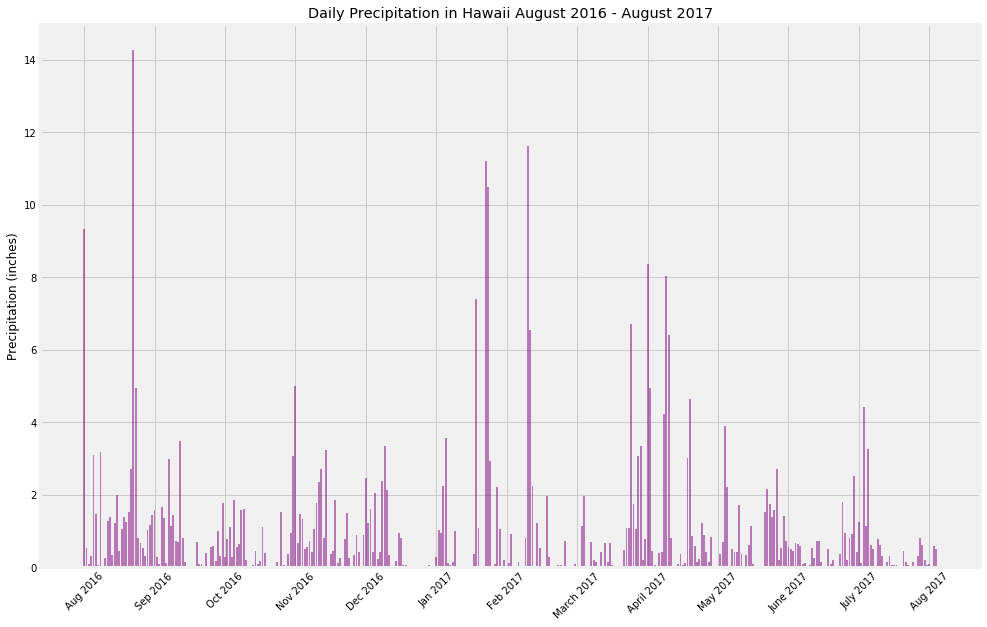

In [5]:
#The dates of my trip
trip_start = '2017-03-08'
trip_end = '2017-03-16'
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
last_date = session.query(func.strftime(Measurement.date)).order_by(Measurement.date.desc()).first()[0]

#Slice string as int then perform timedelta calculation and convert back to string
query_date = str(dt.date(int(last_date[0:4]),int(last_date[5:7]),int(last_date[8:10])) - dt.timedelta(days=365))

# Perform a query to retrieve the data and precipitation scores
data = session.query(Measurement.date,func.sum(Measurement.prcp)).\
                    filter(func.strftime(Measurement.date>query_date)).\
                    filter(func.strftime(Measurement.date<last_date)).\
                    group_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = DataFrame(data,columns=['Date', 'Precipitation'])
df.set_index('Date',inplace=True)
# Sort the dataframe by date
df.sort_values(by=['Date'],ascending=True,inplace=True,)
datelist = ["Aug 2016","Sep 2016","Oct 2016","Nov 2016","Dec 2016","Jan 2017","Feb 2017","March 2017","April 2017","May 2017","June 2017","July 2017","Aug 2017"]

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(15,10))
plt.bar(df.index, df.Precipitation,color="purple",alpha=.5)
plt.xticks(range(0,365,30),datelist,rotation=45)
plt.title("Daily Precipitation in Hawaii August 2016 - August 2017")
plt.ylabel("Precipitation (inches)")
plt.savefig(".\\Output\\prcp.png",bbox_inches="tight")

In [6]:
# Use Pandas to calculate the summary statistics for the precipitation data
df.describe()

,Precipitation
count,364.000000
mean,0.975385
std,1.778758
min,0.000000
25%,0.050000
50%,0.395000
75%,1.082500
max,14.280000


In [7]:
# Design a query to show how many stations are available in this dataset
session.query(Measurement.station).distinct().count()

9

In [8]:
#Save station with most observations as string for next query
station = ''.join(
                    session.query(Measurement.station).\
                        group_by(Measurement.station).\
                        order_by(func.count(Measurement.prcp).desc()).first())
station

'USC00519281'

In [9]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
            filter(Measurement.station == station).all()

[(54.0, 85.0, 71.66378066378067)]

In [10]:
#Query to find station with most temperature observations in time period queried, save as string for next query
tempstation = ''.join(
                        session.query(Measurement.station).\
                            filter(func.strftime(Measurement.date>query_date)).\
                            filter(func.strftime(Measurement.date<last_date)).\
                            group_by(Measurement.station).\
                            order_by(func.count(Measurement.tobs).desc()).first())
tempstation

'USC00519397'

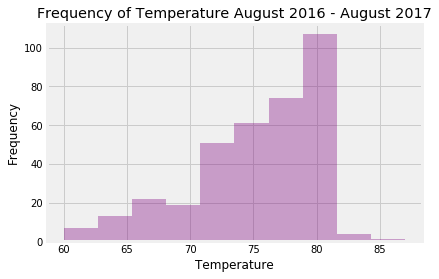

In [11]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tempdata = session.query(Measurement.date,Measurement.tobs).\
                    filter(func.strftime(Measurement.date>query_date)).\
                    filter(func.strftime(Measurement.date<last_date)).\
                    filter(Measurement.station == tempstation).\
                    group_by(Measurement.date).all()

#unpack tuples into list with list comprehension
temp = [x[1] for x in tempdata]
tdf = DataFrame(tempdata,columns=['Date', 'Temperature'])

plt.hist(temp, bins=10,color="purple",alpha=.35)
plt.ylabel("Frequency")
plt.xlabel("Temperature")
plt.title("Frequency of Temperature August 2016 - August 2017")
plt.savefig(".\\Output\\temphist.png",bbox_inches="tight")

In [12]:
tdf.describe()

,Temperature
count,359.000000
mean,75.178273
std,4.958653
min,60.000000
25%,72.000000
50%,77.000000
75%,79.000000
max,87.000000


In [13]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
trip = calc_temps(trip_start, trip_end)
print(trip)

[(64.0, 71.19298245614036, 82.0)]


In [14]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
tmin = trip[0][0]
tavg = trip[0][1]
tmax = trip[0][2]

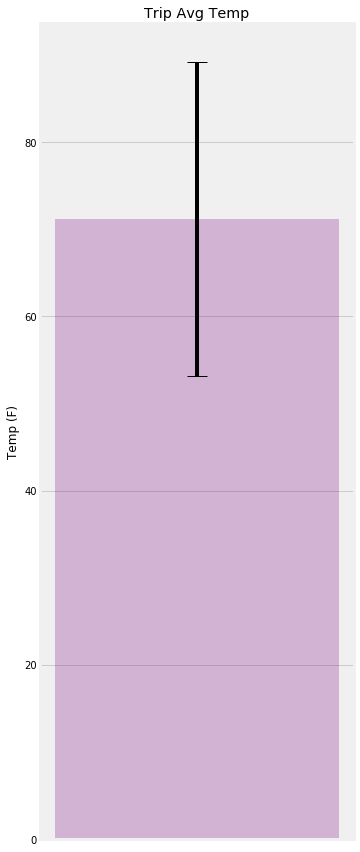

In [15]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.figure(figsize=(5,15))
plt.bar(1,tavg, yerr=tmax-tmin, align='center', alpha=0.25, color='purple',ecolor='black', capsize=10)
plt.ylabel('Temp (F)')
plt.title('Trip Avg Temp')
plt.xticks(range(1))
plt.grid(True)
plt.savefig(".\\Output\\tempavg.png",bbox_inches="tight")

In [16]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
stationdata = session.query(Station.station,Station.name,Station.latitude,Station.longitude,Station.elevation,Measurement.prcp).\
                    filter(Measurement.station == Station.station).\
                    filter(func.strftime(Measurement.date>trip_start)).\
                    filter(func.strftime(Measurement.date<trip_end)).\
                    group_by(Measurement.station).\
                    order_by(Measurement.prcp.desc()).all()
stationdata

[('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.8),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  0.65),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  0.5),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  0.01),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  None)]

## Optional Challenge Assignment

In [17]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [18]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
# Set the start and end date of the trip
d1 = dt.date(2019,3,8)
d2 = dt.date(2019,3,16)
# Use the start and end date to create a range of dates
daterange = [str(d1 + dt.timedelta(days=x)) for x in range((d2-d1).days + 1)]
# Stip off the year and save a list of %m-%d strings
md = [x[5:10] for x in daterange]
# Loop through the list of %m-%d strings and calculate the normals for each date
normals = [daily_normals(x)[0] for x in md]
normals

[(59.0, 68.72413793103448, 78.0),
 (57.0, 68.56140350877193, 75.0),
 (57.0, 69.12280701754386, 75.0),
 (60.0, 69.89285714285714, 82.0),
 (62.0, 69.88888888888889, 80.0),
 (56.0, 69.29629629629629, 77.0),
 (62.0, 70.32758620689656, 77.0),
 (58.0, 68.54716981132076, 76.0),
 (60.0, 69.70370370370371, 78.0)]

In [19]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
dfnorm = DataFrame(normals,columns=["tmin","tavg","tmax"],index=daterange)
dfnorm.head()

,tmin,tavg,tmax
2019-03-08,59.0,68.724138,78.0
2019-03-09,57.0,68.561404,75.0
2019-03-10,57.0,69.122807,75.0
2019-03-11,60.0,69.892857,82.0
2019-03-12,62.0,69.888889,80.0


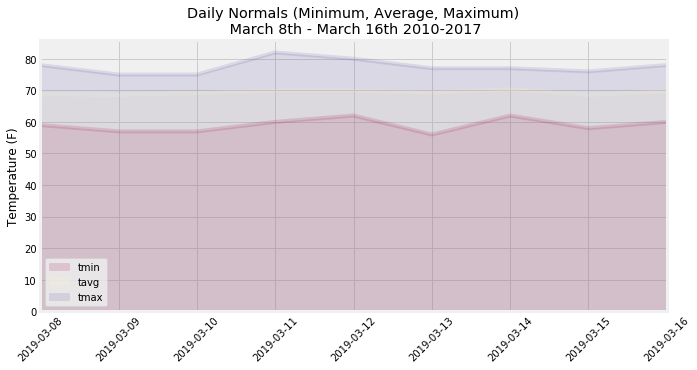

In [20]:
# Plot the daily normals as an area plot with `stacked=False`
cmap = cm.get_cmap('Spectral')
dfnorm.plot(kind='area',stacked=False,rot=45,figsize=(10,5),alpha=.15,grid=True,colormap=cmap)
plt.title("Daily Normals (Minimum, Average, Maximum)\n March 8th - March 16th 2010-2017")
plt.ylabel("Temperature (F)")
plt.savefig(".\\Output\\temparea.png",bbox_inches="tight")

In [21]:
#Prepare a dictionary of stations for better readability from the app
session = Session(engine)
results = session.query(Station.station,Station.name,Station.latitude,Station.longitude,Station.elevation).\
                            group_by(Station.station).all()
y=0
stationlist=[]
for _ in results:
   stationdictouter = {}
   stationdictinner = {}
   stationdictouter[results[y][0]] = stationdictinner
   stationdictinner["Station Name"] = results[y][1]
   stationdictinner["Station Latitude"] = results[y][2]
   stationdictinner["Station Longitude"] = results[y][3]
   y +=1
   stationlist.append(stationdictouter)

In [22]:
stationlist

[{'USC00511918': {'Station Name': 'HONOLULU OBSERVATORY 702.2, HI US',
   'Station Latitude': 21.3152,
   'Station Longitude': -157.9992}},
 {'USC00513117': {'Station Name': 'KANEOHE 838.1, HI US',
   'Station Latitude': 21.4234,
   'Station Longitude': -157.8015}},
 {'USC00514830': {'Station Name': 'KUALOA RANCH HEADQUARTERS 886.9, HI US',
   'Station Latitude': 21.5213,
   'Station Longitude': -157.8374}},
 {'USC00516128': {'Station Name': 'MANOA LYON ARBO 785.2, HI US',
   'Station Latitude': 21.3331,
   'Station Longitude': -157.8025}},
 {'USC00517948': {'Station Name': 'PEARL CITY, HI US',
   'Station Latitude': 21.3934,
   'Station Longitude': -157.9751}},
 {'USC00518838': {'Station Name': 'UPPER WAHIAWA 874.3, HI US',
   'Station Latitude': 21.4992,
   'Station Longitude': -158.0111}},
 {'USC00519281': {'Station Name': 'WAIHEE 837.5, HI US',
   'Station Latitude': 21.45167,
   'Station Longitude': -157.84888999999998}},
 {'USC00519397': {'Station Name': 'WAIKIKI 717.2, HI US',
 